In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import maup
from zipfile import ZipFile
import numpy as np
import os
import shutil

# US House

## Final File - Load

In [4]:
pwd

'/Users/lilyfalk/sandbox/pdv-va'

In [5]:
final = gpd.read_file('./vest_va/va_2018_ushouse/va_2018_ushouse.shp')

In [6]:
final

,COUNTYFP,LOCALITY,VTDST,PRECINCT,CON_DIST,G18HORDEM,G18HORREP,G18HORLIB,G18HORWRI,geometry
0,001,Accomack County,000101,Chincoteague,2,533,1039,0,1,"POLYGON Z ((-75.42507 37.89957 0.00000, -75.42..."
1,001,Accomack County,000201,Atlantic,2,171,482,0,2,"POLYGON Z ((-75.59978 37.87664 0.00000, -75.59..."
2,001,Accomack County,000202,Greenbackville,2,307,595,0,1,"POLYGON Z ((-75.49919 37.93416 0.00000, -75.49..."
3,001,Accomack County,000301,New Church,2,583,490,0,0,"POLYGON Z ((-75.64987 37.92702 0.00000, -75.64..."
4,001,Accomack County,000401,Bloxom,2,118,286,0,0,"POLYGON Z ((-75.71556 37.87513 0.00000, -75.71..."
...,...,...,...,...,...,...,...,...,...,...
2458,179,Stafford County,000401,AQUIA,1,615,247,0,0,"POLYGON Z ((-77.39221 38.48583 0.00000, -77.39..."
2459,195,Wise County,000302,East Stone Gap,9,338,1079,0,3,"POLYGON Z ((-82.80429 36.83206 0.00000, -82.80..."
2460,195,Wise County,000301,Big Stone Gap,9,416,954,0,1,"POLYGON Z ((-82.77275 36.84962 0.00000, -82.77..."
2461,089,Henry County,000503,Stanleytown,9,201,855,0,1,"POLYGON Z ((-79.96638 36.76286 0.00000, -79.96..."


# Election Results: US House

## Read in election results and append since files split accross districts

In [7]:
district = [str(1), str(2), str(3), str(4), str(5), str(6), str(7), str(8), str(9), str(10), str(11)]

In [8]:
#Party info from: https://ballotpedia.org/United_States_House_of_Representatives_elections_in_Virginia,_2018

candidate_to_party_dict = {'Robert Joseph Wittman': 'G18HORREP',
                           'Lavangelene Aereka Williams': 'G18HORDEM', 
                           'All Others': 'G18HORWRI',  
                           'Elaine Goodman Luria': 'G18HORDEM', 
                           'Scott William Taylor': 'G18HORREP',
                           'Robert Cortez Scott': 'G18HORDEM', 
                           'A. Donald McEachin': 'G18HORDEM', 
                           'Ryan Andrew McAdams': 'G18HORREP',
                           'Peter Joseph Wells': 'G18HORLIB', 
                           'Denver Lee Riggleman, III': 'G18HORREP',
                           'Leslie Corkill Cockburn': 'G18HORDEM', 
                           'Benjamin Lee Cline': 'G18HORREP', 
                           'Jennifer Lynn Lewis': 'G18HORDEM',
                           'Abigail Anne Davis Spanberger': 'G18HORDEM', 
                           'David A. Brat': 'G18HORREP',
                           'Joseph Buckler Walton': 'G18HORLIB', 
                           'Donald Sternoff Beyer, Jr.': 'G18HORDEM',
                           'Thomas Siyoung Oh': 'G18HORREP', 
                           'Howard Morgan Griffith': 'G18HORREP',
                           'Anthony Jude Flaccavento': 'G18HORDEM', 
                           'Jennifer Tosini Wexton': 'G18HORDEM',
                           'Barbara Jean Comstock': 'G18HORREP', 
                           'Gerald Edward Connolly': 'G18HORDEM',
                           'Jeffery Anthony Dove, Jr': 'G18HORREP', 
                           'Stevan Michael Porter': 'G18HORLIB'}


In [9]:
elections_by_district = []
for i in district:
    ref = './vest_va/us_house_results_by_district_2018/'
    file_name = ref + 'Virginia_Elections_Database__2018_U_S_House_General_Election_District_'+ i +'_including_precincts.csv'
    results = pd.read_csv(file_name)
    print(i, ' added to list')
    results['CON_DIST'] = i
    for col in results.columns:
        if col in candidate_to_party_dict.keys():
            col_new_name = candidate_to_party_dict.get(col)
            results = results.rename(columns = {col:col_new_name})
    elections_by_district.append(results)

1  added to list
2  added to list
3  added to list
4  added to list
5  added to list
6  added to list
7  added to list
8  added to list
9  added to list
10  added to list
11  added to list


In [10]:
df = pd.concat(elections_by_district, axis = 0)
df = df.reset_index()
df = df[df['County/City'] != 'TOTALS']
df['LOCALITY'] = df['County/City']
df = df.iloc[1:]
df = df.drop(['County/City', 'Ward', 'Total Votes Cast'], axis = 1)
df = df.fillna(value = 0)
df = df[(df['G18HORDEM'] != 'Democratic') & (df['G18HORREP'] != 'Republican') & (df['G18HORLIB'] != 'Libertarian')]
county_dict = pd.Series(final['COUNTYFP'].values, index = final['LOCALITY']).to_dict()
df['COUNTYFP'] = df['LOCALITY'].map(county_dict)

df['G18HORDEM'] = df['G18HORDEM'].map(lambda x: str(x).replace(',', ''))
df['G18HORREP'] = df['G18HORREP'].map(lambda x: str(x).replace(',', ''))
df['G18HORLIB'] = df['G18HORLIB'].map(lambda x: str(x).replace(',', ''))
df['G18HORWRI'] = df['G18HORWRI'].map(lambda x: str(x).replace(',', ''))

df['G18HORDEM'] = df['G18HORDEM'].astype(str).astype(float).astype(int)
df['G18HORREP'] = df['G18HORREP'].astype(str).astype(float).astype(int)
df['G18HORLIB'] = df['G18HORLIB'].astype(str).astype(float).astype(int)
df['G18HORWRI'] = df['G18HORWRI'].astype(str).astype(float).astype(int)

df['CON_DIST'] = df['CON_DIST'].astype(str)

## Re allocate absentee votes

### Account for CD differences by county

In [11]:
cd_abs_prov_prec = df[((df['Pct'].map(lambda x: 'Absentee' in str(x))) &(df['Pct'].map(lambda x: 'CD' in str(x)))) | ((df['Pct'].map(lambda x: 'Provisional' in str(x))) & (df['Pct'].map(lambda x: 'CD' in str(x))))]

In [12]:
cd_abs_prov_prec

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP


In [13]:
df['countyfp_cd'] = df['COUNTYFP'] + '-' + df['CON_DIST']

In [14]:
df

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP,countyfp_cd
1,1,101 - Bowling Green,675,331,0,1,0,Caroline County,033,033-1
2,2,102 - Sparta,482,283,1,1,0,Caroline County,033,033-1
3,3,201 - North Madison,398,469,0,1,0,Caroline County,033,033-1
4,4,202 - South Madison,596,482,0,1,0,Caroline County,033,033-1
5,5,301 - Port Royal,262,182,0,1,0,Caroline County,033,033-1
...,...,...,...,...,...,...,...,...,...,...
2770,162,710 - Powells Creek,189,1154,1,11,17,Prince William County,153,153-11
2771,163,711 - Grayson,269,1236,0,11,21,Prince William County,153,153-11
2772,164,712 - Leesylvania,477,1075,2,11,21,Prince William County,153,153-11
2773,165,Ab - Central Absentee Precinct,1757,5992,5,11,104,Prince William County,153,153-11


### Reallocate the votes

In [15]:
def get_absentee_frac(prec_tot, county_tot, absentee_tot):
    '''
    Keyword arguments: (put inputs to funtions and say what they should be)
    precinct vote total for given candidate (int)
    county vote total for given candidate, absentee and provisional votes not included (int)
    absentee vote total for county for given candidate (int)
    '''
    if county_tot != 0:
        prec_frac = prec_tot/county_tot
        absentee_frac = prec_frac*absentee_tot
    else:
        absentee_frac = 0
    return absentee_frac

In [16]:
absentee_and_prov = df[(df['Pct'].map(lambda x: 'Absentee' in str(x))) | (df['Pct'].map(lambda x: 'Provisional' in str(x)))]
groupby_absentee_and_prov_tot = absentee_and_prov.groupby(['countyfp_cd']).sum()

In [17]:
groupby_absentee_and_prov_tot

,index,G18HORREP,G18HORDEM,G18HORWRI,G18HORLIB
countyfp_cd,,,,,
001-2,35,439,735,0,0
003-5,63,1522,3974,11,0
005-9,27,162,132,0,0
007-7,13,298,186,1,1
009-6,25,431,332,0,0
...,...,...,...,...,...
800-4,515,269,691,0,15
810-2,339,6809,8326,16,0
820-6,527,253,275,0,0


In [18]:
groupby_county_df_tot = df.groupby(['countyfp_cd']).sum()
df_no_absent_or_provisional = df[(df['Pct'].map(lambda x: 'Absentee' not in str(x))) & (df['Pct'].map(lambda x: 'Provisional' not in str(x)))
                                & (df['LOCALITY'] != 'TOTALS')]
groupby_county_tot_no_absentee = df_no_absent_or_provisional.groupby('countyfp_cd').sum()

In [19]:
df_with_absentee_reallocated = df_no_absent_or_provisional.copy()
sum_allocated = 0
prec_sum_w_ab = 0
for index, precinct_total_row_by_candidate in df_no_absent_or_provisional.iterrows():
    #print(precinct_total_row_by_candidate)
    county_fips = precinct_total_row_by_candidate['countyfp_cd']
    county_total_row_by_candidate_no_absentee = groupby_county_tot_no_absentee.loc[county_fips]
    county_absentee_and_provisional_by_candidate = groupby_absentee_and_prov_tot.loc[county_fips]
    #print(precinct_total_row_by_candidate, county_total_row_by_candidate_no_absentee, county_absentee_and_provisional_by_candidate)
    for candidate, votes in county_total_row_by_candidate_no_absentee.to_dict().items():
        prec_tot = precinct_total_row_by_candidate[candidate]
        #print('precinct total: ', prec_tot)
        county_tot = votes
        #print('county total: ', county_tot)
        absentee_tot = county_absentee_and_provisional_by_candidate[candidate]
        #print('absentee total: ', absentee_tot)
        absentee_frac = get_absentee_frac(prec_tot, county_tot, absentee_tot)
        #print('absentee votes to allocate to precinct: ', absentee_frac)
        prec_with_absentee_allocation = prec_tot + absentee_frac
        #print('new precinct total: ', prec_with_absentee_allocation)
       #print(df_with_absentee_reallocated[['G18HORREP', 'G18HORDEM', 'G18HORWRI', 'G18HORLIB']].sum().sum())
        df_with_absentee_reallocated.loc[index, candidate] = round(prec_with_absentee_allocation) #index is row, candidate is column

        #print(df_with_absentee_reallocated[['G18HORREP', 'G18HORDEM', 'G18HORWRI', 'G18HORLIB']].sum().sum())
        sum_allocated = sum_allocated + absentee_frac
        prec_sum_w_ab = prec_sum_w_ab + prec_with_absentee_allocation
        ##So, the number of absentee reallocated looks right... must be a problem with the sum of the prec_tot and absentee_frac?
#print(sum_allocated)
#print(prec_tot)
print(prec_sum_w_ab)
df_with_absentee_reallocated.loc[index, candidate]
#df_with_absentee_reallocated.loc[index, candidate]

3684448.9999999935


24.0

In [20]:
groupby_df_with_absentee_reallocated = df_with_absentee_reallocated.groupby('COUNTYFP').sum()

In [21]:
groupby_county_final = final.groupby(['COUNTYFP']).sum()

In [22]:
df_absentee_reallocate_with_final = pd.merge(groupby_df_with_absentee_reallocated, groupby_county_final, on = 'COUNTYFP', how = 'inner', suffixes = ('_x', '_y'))

In [23]:
df_absentee_reallocate_with_final

,index,G18HORREP_x,G18HORDEM_x,G18HORWRI_x,G18HORLIB_x,G18HORDEM_y,G18HORREP_y,G18HORLIB_y,G18HORWRI_y
COUNTYFP,,,,,,,,,
001,172.0,7025.0,5727.0,12.0,0.0,5729,7025,0,12
003,528.0,18808.0,34407.0,115.0,0.0,34409,18807,0,117
005,104.0,3563.0,1893.0,2.0,0.0,1892,3563,0,2
007,28.0,3879.0,1926.0,4.0,50.0,1926,3879,51,4
009,91.0,8326.0,4216.0,8.0,0.0,4217,8326,0,8
...,...,...,...,...,...,...,...,...,...
800,7915.0,5453.0,23477.0,1921.0,152.0,23477,5453,150,1922
810,12188.0,82585.0,86818.0,201.0,0.0,86822,82586,0,217
820,1569.0,3874.0,3840.0,4.0,0.0,3840,3875,0,4


## Check column sums

In [24]:
df.columns

Index(['index', 'Pct', 'G18HORREP', 'G18HORDEM', 'G18HORWRI', 'CON_DIST',
       'G18HORLIB', 'LOCALITY', 'COUNTYFP', 'countyfp_cd'],
      dtype='object')

In [25]:
column_list = ['G18HORREP', 'G18HORDEM', 'G18HORWRI', 'G18HORLIB']

In [26]:
def sum_checker(df, column_list):
    list_max = 0
    for i in column_list:
        left_sum = df[i+'_x'].sum()
        right_sum = df[i+'_y'].sum()
        if (left_sum == right_sum):
            print('column: ', i, ' have the same sums')
        
        else:
            diff = abs(left_sum - right_sum)
            percent = abs(left_sum - right_sum)/left_sum
            print('column: ', i)
            print('RDH sum is ', str(left_sum))
            print('Partner sum is ', str(right_sum))
            print('their (absolute) difference is ', str(diff))
            print('As a percentage of DF1 this is ', str(round(percent*100,5)) + '%')
            if (percent>list_max):
                list_max = percent
            print('')
    print('The max difference (as a percent of the total of on DF column is: ', str(round(list_max,5)))

In [27]:
sum_checker(df_absentee_reallocate_with_final, column_list)

column:  G18HORREP
RDH sum is  1408713.0
Partner sum is  1408701
their (absolute) difference is  12.0
As a percentage of DF1 this is  0.00085%

column:  G18HORDEM
RDH sum is  1867060.0
Partner sum is  1867061
their (absolute) difference is  1.0
As a percentage of DF1 this is  5e-05%

column:  G18HORWRI
RDH sum is  23356.0
Partner sum is  23454
their (absolute) difference is  98.0
As a percentage of DF1 this is  0.41959%

column:  G18HORLIB
RDH sum is  13988.0
Partner sum is  13995
their (absolute) difference is  7.0
As a percentage of DF1 this is  0.05004%

The max difference (as a percent of the total of on DF column is:  0.0042


The above results are pretty good, the percentage off is very low. 

## Creating unique id to enable merge

In [28]:
final['unique_id'] = final['COUNTYFP'] + final['VTDST'].str.slice(start = 3)

In [29]:
final['unique_id'].nunique()

2441

In [30]:
df_with_absentee_reallocated['vtdst'] = df_with_absentee_reallocated.Pct.str.slice(stop = 3)

In [31]:
def vtdst_changer(vtdst):
    if (vtdst[1:3] == ' -'):
        two_lead_zero = '00' + vtdst[:1]
        return two_lead_zero
    elif (vtdst[1:3] == '- '):
        two_lead_zero = '00' + vtdst[:1]
        return two_lead_zero
    elif (vtdst[-1:] == ' '):
        one_lead_zero = '0' + vtdst[:2]
        return one_lead_zero
    elif (vtdst[-1:] == '-'):
        one_lead_zero = '0' + vtdst[:2]
        return one_lead_zero
    else:
        return vtdst

In [32]:
df_with_absentee_reallocated['vtdst'] = df_with_absentee_reallocated['vtdst'].apply(vtdst_changer)
df_with_absentee_reallocated[df_with_absentee_reallocated['vtdst'].str.slice(start = -1) == '-'] #check that above worked

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP,countyfp_cd,vtdst


In [33]:
df_with_absentee_reallocated['unique_id'] = df_with_absentee_reallocated['COUNTYFP'] + df_with_absentee_reallocated['vtdst']

In [34]:
df_id_count = df_with_absentee_reallocated['unique_id'].value_counts()
df_double_list = df_id_count[df_id_count > 1].index
final_id_count = final.unique_id.value_counts()
final_double_list = final_id_count[final_id_count > 1].index
print(set(df_double_list) - set(final_double_list))
print(set(final_double_list) - set(df_double_list))

set()
set()


**USE CON_DIST to account for the rest of the unique ids**

In [35]:
(final['unique_id'] + final['CON_DIST']).nunique()

2463

In [36]:
(df_with_absentee_reallocated['unique_id'] + df_with_absentee_reallocated['CON_DIST']).nunique()

2462

In [37]:
df_with_absentee_reallocated['unique_id_1'] = df_with_absentee_reallocated['unique_id'] + '-' + df_with_absentee_reallocated['CON_DIST']
final['unique_id_1'] = final['unique_id'] + '-' + final['CON_DIST']

In [38]:
print(set(final['unique_id_1']) - set(df_with_absentee_reallocated['unique_id_1']))
print(set(df_with_absentee_reallocated['unique_id_1']) - set(final['unique_id_1']))

{'059700-11', '003599-5', '003499-5'}
{'003507-5', '003407-5'}


In [39]:
d = {'003407-5':'003499-5', '003507-5': '003599-5'}
df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id_1'].isin(d.keys()), 'unique_id_1'] = df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id_1'].isin(d.keys()), 'unique_id_1'].map(d)

In [40]:
df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id'] == '003407']

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP,countyfp_cd,vtdst,unique_id,unique_id_1
976,22.0,407 - Biscuit Run,321.0,1065.0,2.0,5,0.0,Albemarle County,003,003-5,407,003407,003499-5


In [41]:
final.loc[final['unique_id'] == '003499']

,COUNTYFP,LOCALITY,VTDST,PRECINCT,CON_DIST,G18HORDEM,G18HORREP,G18HORLIB,G18HORWRI,geometry,unique_id,unique_id_1
29,003,Albemarle County,000499,Biscuit Run,5,1065,321,0,2,"POLYGON Z ((-78.53848 37.98576 0.00000, -78.53...",003499,003499-5


In [42]:
print(set(final['unique_id_1']) - set(df_with_absentee_reallocated['unique_id_1']))
print(set(df_with_absentee_reallocated['unique_id_1']) - set(final['unique_id_1']))

{'059700-11'}
set()


In [43]:
assert final.unique_id_1.nunique() == final.shape[0]

# Shapefile

In [44]:
pwd

'/Users/lilyfalk/sandbox/pdv-va'

In [45]:
#path = ('./vest_va/census_shps_by_county_all_unzip/')
#os.chdir(path)
county_fips = []
for directory in os.listdir('./vest_va/census_shps_by_county_all_unzip/'):
    if not directory[0] == '.':
        county_fips.append(directory[-5:])

In [46]:
proj = final.crs

In [47]:
#path = ('./vest_va/')
#os.chdir(path)
county_vtds = []

for i in county_fips: #i dont have fips_codes file
    ref = './vest_va/census_shps_by_county_all_unzip/partnership_shapefiles_19v2_'
    vtd_ref = ref + i + '/PVS_19_v2_vtd_' + i + '.shp' 
    vtd_shp = gpd.read_file(vtd_ref)
    print(i, ' added to list')
    county_vtds.append(vtd_shp)

51580  added to list
51117  added to list
51121  added to list
51119  added to list
51770  added to list
51181  added to list
51175  added to list
51143  added to list
51520  added to list
51127  added to list
51740  added to list
51111  added to list
51145  added to list
51510  added to list
51187  added to list
51173  added to list
51001  added to list
51650  added to list
51037  added to list
51063  added to list
51097  added to list
51099  added to list
51009  added to list
51660  added to list
51036  added to list
51031  added to list
51007  added to list
51053  added to list
51065  added to list
51091  added to list
51047  added to list
51071  added to list
51085  added to list
51049  added to list
51620  added to list
51680  added to list
51025  added to list
51013  added to list
51810  added to list
51077  added to list
51083  added to list
51079  added to list
51610  added to list
51041  added to list
51015  added to list
51023  added to list
51820  added to list
51169  added 

In [49]:
global shp
shp = gpd.GeoDataFrame(pd.concat(county_vtds, axis = 0) , crs = proj) 

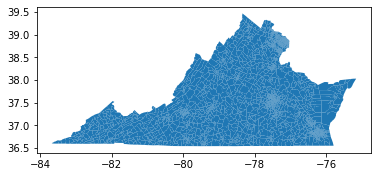

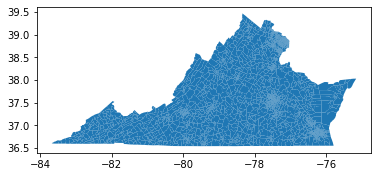

In [50]:
shp.plot()
final.plot()

In [51]:
shp.shape

(2462, 16)

In [52]:
final.shape

(2463, 12)

In [53]:
shp['unique_id'] = shp['COUNTYFP'] + shp['VTDST'].str.slice(start = 3)

In [54]:
shp['unique_id_1'] = shp['unique_id']

In [55]:
d = {'003407':'003499', '003507': '003599'}
shp.loc[shp['unique_id'].isin(d.keys()), 'unique_id_1']=shp.loc[shp['unique_id'].isin(d.keys()), 'unique_id_1'].map(d)
shp.loc[shp['unique_id'].isin(d.keys())]

,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,NAME,VINTAGE,FUNCSTAT,JUSTIFY,MTFCC,geometry,unique_id,unique_id_1
28,51,003,000407,Biscuit Run,A,00,None,None,None,None,Biscuit Run,90,N,None,G5240,"POLYGON Z ((-78.53848 37.98576 0.00000, -78.53...",003407,003499
29,51,003,000507,Pantops,A,00,None,None,None,None,Pantops,90,N,None,G5240,"POLYGON Z ((-78.45505 38.04404 0.00000, -78.45...",003507,003599


In [56]:
len(set(final.unique_id) - set(shp.unique_id_1))

8

In [57]:
len(set(shp['unique_id_1']) - set(final.unique_id))

28

In [58]:
set(shp.unique_id_1)  - set(final.unique_id)

{'041113',
 '041216',
 '041314',
 '041319',
 '041412',
 '077011',
 '077012',
 '095041',
 '095042',
 '121032',
 '153061',
 '153062',
 '153114',
 '153315',
 '161401',
 '191021',
 '191022',
 '510112',
 '510309',
 '520041',
 '520042',
 '550064',
 '550065',
 '685031',
 '685032',
 '750004',
 '760215',
 '760415'}

In [59]:
final_uniqe_not_in_shp = list(set(final.unique_id) - set(shp.unique_id_1))

In [60]:
final[final['unique_id'].isin(final_uniqe_not_in_shp)]

,COUNTYFP,LOCALITY,VTDST,PRECINCT,CON_DIST,G18HORDEM,G18HORREP,G18HORLIB,G18HORWRI,geometry,unique_id,unique_id_1
1304,153,Prince William County,000106,Westgate,1,962,296,0,1,"POLYGON Z ((-77.53727 38.77568 0.00000, -77.53...",153106,153106-1
1731,550,Chesapeake City,000040,River Birch,3,1389,0,0,186,"POLYGON Z ((-76.23347 36.78440 0.00000, -76.23...",550040,550040-3
1733,550,Chesapeake City,000047,Green Sea,4,277,549,15,1,"POLYGON Z ((-76.28603 36.69691 0.00000, -76.28...",550047,550047-4
2236,077,Grayson County,000401,Fries,9,107,221,0,0,"MULTIPOLYGON Z (((-81.08851 36.76885 0.00000, ...",077401,077401-9
2240,095,James City County,000104,Berkeley D,2,444,369,0,1,"MULTIPOLYGON Z (((-76.75418 37.24672 0.00000, ...",095104,095104-2
2260,685,Manassas Park City,000003,Precinct Three,10,939,513,0,0,"MULTIPOLYGON Z (((-77.45337 38.76934 0.00000, ...",685003,685003-10
2261,191,Washington County,000702,WALLACE,9,143,449,0,0,"MULTIPOLYGON Z (((-82.14454 36.66976 0.00000, ...",191702,191702-9
2341,520,Bristol City,000004,Fourth Ward,9,603,1618,0,3,"MULTIPOLYGON Z (((-82.15659 36.63121 0.00000, ...",520004,520004-9


In [61]:
shp_unique_id_missing = list(set(shp.unique_id_1) - set(final.unique_id))
#plot fries part 1 and 2, should come out the same

In [62]:
shp[shp['unique_id'].isin(shp_unique_id_missing)]

,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,NAME,VINTAGE,FUNCSTAT,JUSTIFY,MTFCC,geometry,unique_id,unique_id_1
23,51,121,002032,B-3 part 2,A,00,None,None,None,None,B-3 part 2,90,N,None,G5240,"POLYGON Z ((-80.44921 37.16344 0.00000, -80.44...",121032,121032
24,51,121,004032,D-3 part 2,A,00,None,None,None,None,D-3 part 2,90,N,None,G5240,"POLYGON Z ((-80.51937 37.13193 0.00000, -80.51...",121032,121032
3,51,520,000041,Fourth Ward Part 1 Voting District,P,V2,None,None,None,None,Fourth Ward Part 1,90,S,None,G5240,"POLYGON Z ((-82.16028 36.62071 0.00000, -82.15...",520041,520041
4,51,520,000042,Fourth Ward Part 2 Voting District,P,V2,None,None,None,None,Fourth Ward Part 2,90,S,None,G5240,"POLYGON Z ((-82.12869 36.64952 0.00000, -82.12...",520042,520042
20,51,510,000112,Alex Renew Voting District,A,V2,None,None,None,None,Alex Renew,90,N,None,G5240,"POLYGON Z ((-77.07746 38.80083 0.00000, -77.07...",510112,510112
21,51,510,000309,Olympus Condo Voting District,A,V2,None,None,None,None,Olympus Condo,90,N,None,G5240,"POLYGON Z ((-77.14368 38.81340 0.00000, -77.14...",510309,510309
14,51,077,004011,Fries Part 1 Voting District,P,V2,None,None,None,None,Fries Part 1,90,S,None,G5240,"POLYGON Z ((-81.08851 36.76885 0.00000, -81.08...",077011,077011
15,51,077,004012,Fries Part 2 Voting District,P,V2,None,None,None,None,Fries Part 2,90,S,None,G5240,"POLYGON Z ((-81.01449 36.70041 0.00000, -81.01...",077012,077012
13,51,041,000113,Iron Bridge North Voting District,A,V2,None,None,None,None,Iron Bridge North,90,N,None,G5240,"POLYGON Z ((-77.50202 37.37361 0.00000, -77.50...",041113,041113
14,51,041,000216,Ridgedale Voting District,A,V2,None,None,None,None,Ridgedale,90,N,None,G5240,"POLYGON Z ((-77.53608 37.41786 0.00000, -77.53...",041216,041216


In [63]:
set(final.unique_id) - set(shp.unique_id_1) 

{'077401',
 '095104',
 '153106',
 '191702',
 '520004',
 '550040',
 '550047',
 '685003'}

In [64]:
final.unique_id.nunique()

2441

In [65]:
df_with_absentee_reallocated.unique_id.nunique()

2440

In [66]:
(final.COUNTYFP + final.VTDST.str.slice(start = 3)).nunique()

2441

In [67]:
final.head()

,COUNTYFP,LOCALITY,VTDST,PRECINCT,CON_DIST,G18HORDEM,G18HORREP,G18HORLIB,G18HORWRI,geometry,unique_id,unique_id_1
0,001,Accomack County,000101,Chincoteague,2,533,1039,0,1,"POLYGON Z ((-75.42507 37.89957 0.00000, -75.42...",001101,001101-2
1,001,Accomack County,000201,Atlantic,2,171,482,0,2,"POLYGON Z ((-75.59978 37.87664 0.00000, -75.59...",001201,001201-2
2,001,Accomack County,000202,Greenbackville,2,307,595,0,1,"POLYGON Z ((-75.49919 37.93416 0.00000, -75.49...",001202,001202-2
3,001,Accomack County,000301,New Church,2,583,490,0,0,"POLYGON Z ((-75.64987 37.92702 0.00000, -75.64...",001301,001301-2
4,001,Accomack County,000401,Bloxom,2,118,286,0,0,"POLYGON Z ((-75.71556 37.87513 0.00000, -75.71...",001401,001401-2


In [68]:
df_with_absentee_reallocated.head()

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP,countyfp_cd,vtdst,unique_id,unique_id_1
1,1.0,101 - Bowling Green,725.0,357.0,0.0,1,0.0,Caroline County,033,033-1,101,033101,033101-1
2,3.0,102 - Sparta,518.0,305.0,1.0,1,0.0,Caroline County,033,033-1,102,033102,033102-1
3,4.0,201 - North Madison,428.0,506.0,0.0,1,0.0,Caroline County,033,033-1,201,033201,033201-1
4,5.0,202 - South Madison,640.0,520.0,0.0,1,0.0,Caroline County,033,033-1,202,033202,033202-1
5,7.0,301 - Port Royal,281.0,196.0,0.0,1,0.0,Caroline County,033,033-1,301,033301,033301-1


In [69]:
shp.head()

,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,NAME,VINTAGE,FUNCSTAT,JUSTIFY,MTFCC,geometry,unique_id,unique_id_1
0,51,580,000101,Precinct 1-1,A,00,None,None,None,None,Precinct 1-1,90,N,None,G5240,"POLYGON Z ((-80.00136 37.78983 0.00000, -80.00...",580101,580101
1,51,580,000201,Precinct 2-1,A,00,None,None,None,None,Precinct 2-1,90,N,None,G5240,"POLYGON Z ((-79.99129 37.79115 0.00000, -79.99...",580201,580201
2,51,580,000301,Precinct 3-1,A,00,None,None,None,None,Precinct 3-1,90,N,None,G5240,"POLYGON Z ((-79.99661 37.78701 0.00000, -79.99...",580301,580301
3,51,580,000401,Precinct 4-1,A,00,None,None,None,None,Precinct 4-1,90,N,None,G5240,"POLYGON Z ((-79.99797 37.78069 0.00000, -79.99...",580401,580401
4,51,580,000501,Precinct 5-1,A,00,None,None,None,None,Precinct 5-1,90,N,None,G5240,"POLYGON Z ((-80.00899 37.76259 0.00000, -80.00...",580501,580501


### Refining shp unique id match to election results

In [70]:
shp_id_list = list(set(shp['unique_id']) - set(df_with_absentee_reallocated['unique_id']))
df_id_list = list(set(df_with_absentee_reallocated['unique_id']) - set(shp['unique_id']))

In [71]:
print(shp.shape[0])
print(len(shp_id_list))
print(df_with_absentee_reallocated.shape[0])
len(df_id_list)

2462
29
2462


8

In [72]:
shp['COUNTYFP'][shp['unique_id'].isin(shp_id_list)].value_counts()

041    5
153    4
520    2
121    2
095    2
685    2
550    2
191    2
760    2
510    2
077    2
059    1
750    1
161    1
Name: COUNTYFP, dtype: int64

**See below, hand check all by Name/Precinct/NAMELSAD, then check via plot**

In [73]:
shp[shp['unique_id'].isin(shp_id_list)]

,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,NAME,VINTAGE,FUNCSTAT,JUSTIFY,MTFCC,geometry,unique_id,unique_id_1
23,51,121,002032,B-3 part 2,A,00,None,None,None,None,B-3 part 2,90,N,None,G5240,"POLYGON Z ((-80.44921 37.16344 0.00000, -80.44...",121032,121032
24,51,121,004032,D-3 part 2,A,00,None,None,None,None,D-3 part 2,90,N,None,G5240,"POLYGON Z ((-80.51937 37.13193 0.00000, -80.51...",121032,121032
3,51,520,000041,Fourth Ward Part 1 Voting District,P,V2,None,None,None,None,Fourth Ward Part 1,90,S,None,G5240,"POLYGON Z ((-82.16028 36.62071 0.00000, -82.15...",520041,520041
4,51,520,000042,Fourth Ward Part 2 Voting District,P,V2,None,None,None,None,Fourth Ward Part 2,90,S,None,G5240,"POLYGON Z ((-82.12869 36.64952 0.00000, -82.12...",520042,520042
20,51,510,000112,Alex Renew Voting District,A,V2,None,None,None,None,Alex Renew,90,N,None,G5240,"POLYGON Z ((-77.07746 38.80083 0.00000, -77.07...",510112,510112
21,51,510,000309,Olympus Condo Voting District,A,V2,None,None,None,None,Olympus Condo,90,N,None,G5240,"POLYGON Z ((-77.14368 38.81340 0.00000, -77.14...",510309,510309
14,51,077,004011,Fries Part 1 Voting District,P,V2,None,None,None,None,Fries Part 1,90,S,None,G5240,"POLYGON Z ((-81.08851 36.76885 0.00000, -81.08...",077011,077011
15,51,077,004012,Fries Part 2 Voting District,P,V2,None,None,None,None,Fries Part 2,90,S,None,G5240,"POLYGON Z ((-81.01449 36.70041 0.00000, -81.01...",077012,077012
13,51,041,000113,Iron Bridge North Voting District,A,V2,None,None,None,None,Iron Bridge North,90,N,None,G5240,"POLYGON Z ((-77.50202 37.37361 0.00000, -77.50...",041113,041113
14,51,041,000216,Ridgedale Voting District,A,V2,None,None,None,None,Ridgedale,90,N,None,G5240,"POLYGON Z ((-77.53608 37.41786 0.00000, -77.53...",041216,041216


In [74]:
df_with_absentee_reallocated[(df_with_absentee_reallocated['COUNTYFP'] == '121') & (df_with_absentee_reallocated['Pct'].str.contains('D'))]

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP,countyfp_cd,vtdst,unique_id,unique_id_1
2187,211.0,401 - Precinct D-1,566.0,402.0,0.0,9,0.0,Montgomery County,121,121-9,401,121401,121401-9
2188,212.0,402 - Precinct D-2,1055.0,431.0,0.0,9,0.0,Montgomery County,121,121-9,402,121402,121402-9
2189,213.0,403 - Precinct D-3,794.0,353.0,0.0,9,0.0,Montgomery County,121,121-9,403,121403,121403-9
2190,215.0,404 - Precinct D-4,464.0,183.0,0.0,9,0.0,Montgomery County,121,121-9,404,121404,121404-9
2191,216.0,405 - Precinct D-5,933.0,760.0,2.0,9,0.0,Montgomery County,121,121-9,405,121405,121405-9


In [75]:
shp[(shp['unique_id'].str.slice(stop = 3) == '550') & (shp['NAME'].str.contains('Green'))] #041 042

,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,NAME,VINTAGE,FUNCSTAT,JUSTIFY,MTFCC,geometry,unique_id,unique_id_1
11,51,550,000007,Greenbrier Voting District,A,V2,None,None,None,None,Greenbrier,90,N,None,G5240,"POLYGON Z ((-76.21963 36.75324 0.00000, -76.21...",550007,550007
49,51,550,000056,Green Tree Voting District,A,V2,None,None,None,None,Green Tree,90,N,None,G5240,"POLYGON Z ((-76.25327 36.74277 0.00000, -76.25...",550056,550056


In [76]:
final[(final['COUNTYFP'] == '550') & (final['PRECINCT'].str.contains('Green'))] #760215 

,COUNTYFP,LOCALITY,VTDST,PRECINCT,CON_DIST,G18HORDEM,G18HORREP,G18HORLIB,G18HORWRI,geometry,unique_id,unique_id_1
1705,550,Chesapeake City,000007,Greenbrier,4,786,1070,18,2,"POLYGON Z ((-76.22488 36.75309 0.00000, -76.22...",550007,550007-4
1733,550,Chesapeake City,000047,Green Sea,4,277,549,15,1,"POLYGON Z ((-76.28603 36.69691 0.00000, -76.28...",550047,550047-4
1739,550,Chesapeake City,000056,Green Tree,3,885,0,0,146,"POLYGON Z ((-76.24810 36.75531 0.00000, -76.24...",550056,550056-3


In [77]:
shp.unique_id.nunique()

2461

In [78]:
shp.shape[0]

2462

In [79]:
df_with_absentee_reallocated[df_with_absentee_reallocated['unique_id'].isin(df_id_list)]

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP,countyfp_cd,vtdst,unique_id,unique_id_1
169,178.0,106 - Westgate,296.0,961.0,1.0,1,0.0,Prince William County,153,153-1,106,153106,153106-1
295,38.0,104- Berkeley D,368.0,444.0,1.0,2,0.0,James City County,095,095-2,104,095104,095104-2
482,28.0,40 - River Birch,0.0,1388.0,186.0,3,0.0,Chesapeake City,550,550-3,040,550040,550040-3
702,29.0,47 - Green Sea,550.0,277.0,1.0,4,15.0,Chesapeake City,550,550-4,047,550047,550047-4
2020,42.0,4 - Fourth Ward,1618.0,602.0,3.0,9,0.0,Bristol City,520,520-9,004,520004,520004-9
2124,150.0,401 - Fries,221.0,107.0,0.0,9,0.0,Grayson County,077,077-9,401,077401,077401-9
2353,399.0,702 - Wallace,449.0,143.0,0.0,9,0.0,Washington County,191,191-9,702,191702,191702-9
2579,325.0,3 - Precinct Three,513.0,939.0,0.0,10,0.0,Manassas Park City,685,685-10,003,685003,685003-10


In [82]:
len(df_id_list)

8

In [84]:
df_with_absentee_reallocated[(df_with_absentee_reallocated['Pct'].str.contains('Westgate'))]

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP,countyfp_cd,vtdst,unique_id,unique_id_1
169,178.0,106 - Westgate,296.0,961.0,1.0,1,0.0,Prince William County,153,153-1,106,153106,153106-1
1966,153.0,613 - Westgate,1172.0,1340.0,1.0,8,0.0,Fairfax County,059,059-8,613,059613,059613-8


In [85]:
df_county_rep = list(df_with_absentee_reallocated['COUNTYFP'][df_with_absentee_reallocated['unique_id'].isin(df_id_list)])

In [86]:
df_with_absentee_reallocated[df_with_absentee_reallocated['COUNTYFP'].isin(df_county_rep) & df_with_absentee_reallocated['unique_id'].isin(df_id_list)]

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP,countyfp_cd,vtdst,unique_id,unique_id_1
169,178.0,106 - Westgate,296.0,961.0,1.0,1,0.0,Prince William County,153,153-1,106,153106,153106-1
295,38.0,104- Berkeley D,368.0,444.0,1.0,2,0.0,James City County,095,095-2,104,095104,095104-2
482,28.0,40 - River Birch,0.0,1388.0,186.0,3,0.0,Chesapeake City,550,550-3,040,550040,550040-3
702,29.0,47 - Green Sea,550.0,277.0,1.0,4,15.0,Chesapeake City,550,550-4,047,550047,550047-4
2020,42.0,4 - Fourth Ward,1618.0,602.0,3.0,9,0.0,Bristol City,520,520-9,004,520004,520004-9
2124,150.0,401 - Fries,221.0,107.0,0.0,9,0.0,Grayson County,077,077-9,401,077401,077401-9
2353,399.0,702 - Wallace,449.0,143.0,0.0,9,0.0,Washington County,191,191-9,702,191702,191702-9
2579,325.0,3 - Precinct Three,513.0,939.0,0.0,10,0.0,Manassas Park City,685,685-10,003,685003,685003-10


In [87]:
#important
merge_dict = {'153114': '153109-1', #? do not look like they matchPiney Branch
 '153061': '153106-1', #Westgate part 1 -- on map looks like it this is the only match ?merge
 '153062': '153106-1', #?merge Westgate part 2 -- westgate is normal Polygon z in final file
 #: 153315 - Williams voting District from shp does not seem to have a match in df
 '191021': '191702-9', #merge Wallace part 1
 '191022': '191702-9', #merge Wallace part 2 -- multipolygon in final file - merge shp
 '760415': '760114-4', #? does not look like it matches based on polygons only one that contains 4 that is not in shp file also??
 #no match in 760 county for : 760215 from shp dataset
 #no match in 750 county for : '750004'
 '685031': '685003-10', #merge Precint three part 1
 '685032': '685003-10', #merge Precinct three part 2
 #: 059700 -- no match - in Final and shp, not in df -- zero votes
 '095041': '095104-2', #merge Berkeley part 1
 '095042': '095104-2', #merge Berkeley part 2
 '161401': '161405-6', # merge with exsiting 161405 "North LINDENWOOD" with this "South LINDENWOOD"
 '550064': '550006-4', # merge Deep creek II -- merge with existing 550006
 '550065': '550049-4', # merge Waterway II -- merge with exisiting 550049
 '041113': '041111-4', # merge with existing 041111
 '077011': '077401-9', #merge Fries part 1 - merge
 '077012': '077401-9', #merge Fries part 2 - merge
 #: 510302 and 
 #: 510112 do not seem to have matches in df from shp
 '520041': '520004-9', #merge Fourth Ward Part 1
 '520042': '520004-9', #merge Fourth Ward Part 2
 '121032': '121203-9', #vtdst = 002032 - B3 part 2 merge with part 1 existing (121203)
 #'121032': '121403-9' #vtdst = 004032 - D3 part 2 - merge with part 1 existing -- this and previous need new ID to distinguish ... or not just cut it ?121032 does not match the final version
    #'550040-3': , #River birch missing in shp
    #'550047-4':  #Green Sea missing in shp
} 

#10 merge (existing in df, merge in shp)
#6 in shp not in df
#2 in df not in
#2 in shp and df just need dict
#2 in shp merge to existing id
#so, 10 remain as is in shp, 10 -->5 in shp due to merge
#can see creeks/rivers missing... add back in?

In [88]:
#important
shp['unique_id_2'] = shp['unique_id']
shp.loc[shp['unique_id'].isin(merge_dict.keys()), 'unique_id_2'] = shp.loc[shp['unique_id'].isin(merge_dict.keys()), 'unique_id_2'].map(merge_dict)
shp.loc[shp['unique_id'].isin(merge_dict.keys())]

,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,NAME,VINTAGE,FUNCSTAT,JUSTIFY,MTFCC,geometry,unique_id,unique_id_1,unique_id_2
23,51,121,002032,B-3 part 2,A,00,None,None,None,None,B-3 part 2,90,N,None,G5240,"POLYGON Z ((-80.44921 37.16344 0.00000, -80.44...",121032,121032,121203-9
24,51,121,004032,D-3 part 2,A,00,None,None,None,None,D-3 part 2,90,N,None,G5240,"POLYGON Z ((-80.51937 37.13193 0.00000, -80.51...",121032,121032,121203-9
3,51,520,000041,Fourth Ward Part 1 Voting District,P,V2,None,None,None,None,Fourth Ward Part 1,90,S,None,G5240,"POLYGON Z ((-82.16028 36.62071 0.00000, -82.15...",520041,520041,520004-9
4,51,520,000042,Fourth Ward Part 2 Voting District,P,V2,None,None,None,None,Fourth Ward Part 2,90,S,None,G5240,"POLYGON Z ((-82.12869 36.64952 0.00000, -82.12...",520042,520042,520004-9
14,51,077,004011,Fries Part 1 Voting District,P,V2,None,None,None,None,Fries Part 1,90,S,None,G5240,"POLYGON Z ((-81.08851 36.76885 0.00000, -81.08...",077011,077011,077401-9
15,51,077,004012,Fries Part 2 Voting District,P,V2,None,None,None,None,Fries Part 2,90,S,None,G5240,"POLYGON Z ((-81.01449 36.70041 0.00000, -81.01...",077012,077012,077401-9
13,51,041,000113,Iron Bridge North Voting District,A,V2,None,None,None,None,Iron Bridge North,90,N,None,G5240,"POLYGON Z ((-77.50202 37.37361 0.00000, -77.50...",041113,041113,041111-4
56,51,550,000065,Waterway II Voting District,A,V2,None,None,None,None,Waterway II,90,N,None,G5240,"POLYGON Z ((-76.20982 36.74850 0.00000, -76.20...",550065,550065,550049-4
62,51,550,000064,Deep Creek II Voting District,A,V2,None,None,None,None,Deep Creek II,90,N,None,G5240,"POLYGON Z ((-76.49148 36.55072 0.00000, -76.48...",550064,550064,550006-4
23,51,161,000401,South Lindenwood,A,00,None,None,None,None,South Lindenwood,90,N,None,G5240,"POLYGON Z ((-79.88106 37.26168 0.00000, -79.88...",161401,161401,161405-6


In [89]:
#important
shp = shp.dissolve(by = 'unique_id_2', as_index = False)

In [90]:
#important
df_with_absentee_reallocated['unique_id_2'] = df_with_absentee_reallocated['unique_id']
df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id'].isin(df_double_list), 'unique_id_2'] = df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id'].isin(df_double_list), 'unique_id_1']
df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id'].isin(df_double_list)]

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP,countyfp_cd,vtdst,unique_id,unique_id_1,unique_id_2
88,102.0,202 - Jamestown B,952.0,1383.0,2.0,1,0.0,James City County,095,095-1,202,095202,095202-1,095202-1
98,113.0,504 - Roberts D,11.0,9.0,0.0,1,0.0,James City County,095,095-1,504,095504,095504-1,095504-1
173,182.0,110 - Buckland Mills,295.0,261.0,0.0,1,0.0,Prince William County,153,153-1,110,153110,153110-1,153110-1
175,184.0,112 - Burke-nickens,39.0,35.0,0.0,1,0.0,Prince William County,153,153-1,112,153112,153112-1,153112-1
183,193.0,210 - Penn,930.0,770.0,4.0,1,0.0,Prince William County,153,153-1,210,153210,153210-1,153210-1
193,203.0,312 - Triangle,78.0,281.0,0.0,1,0.0,Prince William County,153,153-1,312,153312,153312-1,153312-1
205,216.0,609 - King,3.0,46.0,0.0,1,0.0,Prince William County,153,153-1,609,153609,153609-1,153609-1
215,264.0,103 - Travelers Rest,2.0,5.0,0.0,1,0.0,Spotsylvania County,177,177-1,103,177103,177103-1,177103-1
218,268.0,402 - Parkside,846.0,1089.0,3.0,1,0.0,Spotsylvania County,177,177-1,402,177402,177402-1,177402-1
221,271.0,702 - Brents Mill,494.0,627.0,4.0,1,0.0,Spotsylvania County,177,177-1,702,177702,177702-1,177702-1


In [91]:
#important
# mimmick changes in final file so that can join on unique id later
final['unique_id_2'] = final['unique_id']
final.loc[final['unique_id'].isin(df_double_list), 'unique_id_2'] = final.loc[final['unique_id'].isin(df_double_list), 'unique_id_1']
final.loc[final['unique_id'].isin(df_double_list)]

,COUNTYFP,LOCALITY,VTDST,PRECINCT,CON_DIST,G18HORDEM,G18HORREP,G18HORLIB,G18HORWRI,geometry,unique_id,unique_id_1,unique_id_2
1803,650,Hampton City,000215,TYLER (CD 3),3,380,0,0,28,"POLYGON Z ((-76.36283 37.05127 0.00000, -76.36...",650215,650215-3,650215-3
2232,550,Chesapeake City,000020,E W Chittum (CD 4),4,825,988,28,2,"POLYGON Z ((-76.43452 36.81465 0.00000, -76.43...",550020,550020-4,550020-4
2233,550,Chesapeake City,000020,E W Chittum (CD 3),3,16,0,0,4,"MULTIPOLYGON Z (((-76.41226 36.80753 0.00000, ...",550020,550020-3,550020-3
2234,059,Fairfax County,000513,Saint Albans (CD 8),8,398,176,0,1,"POLYGON Z ((-77.17195 38.83980 0.00000, -77.17...",059513,059513-8,059513-8
2235,059,Fairfax County,000513,Saint Albans (CD 11),11,876,320,21,0,"MULTIPOLYGON Z (((-77.17507 38.82548 0.00000, ...",059513,059513-11,059513-11
2239,650,Hampton City,000215,TYLER (CD 2),2,36,12,0,0,"POLYGON Z ((-76.36144 37.05458 0.00000, -76.35...",650215,650215-2,650215-2
2241,095,James City County,000504,Roberts D (CD 1),1,9,11,0,0,"POLYGON Z ((-76.74957 37.23549 0.00000, -76.74...",095504,095504-1,095504-1
2242,095,James City County,000504,Roberts D (CD 2),2,1338,1152,0,4,"POLYGON Z ((-76.76726 37.22034 0.00000, -76.76...",095504,095504-2,095504-2
2267,710,Norfolk City,000104,Titustown (CD 2),2,619,87,0,4,"POLYGON Z ((-76.31892 36.94388 0.00000, -76.31...",710104,710104-2,710104-2
2268,710,Norfolk City,000104,Titustown (CD 3),3,47,0,0,1,"POLYGON Z ((-76.28979 36.91112 0.00000, -76.28...",710104,710104-3,710104-3


In [92]:
#important
merge_df_list = ['153109-1', #? do not look like they matchPiney Branch
'153106-1', #Westgate part 1 -- on map looks like it this is the only match ?merge
'153106-1', #?merge Westgate part 2 -- westgate is normal Polygon z in final file
 #: 153315 - Williams voting District from shp does not seem to have a match in df
'191702-9', #merge Wallace part 1
'191702-9', #merge Wallace part 2 -- multipolygon in final file - merge shp
'760114-4', #? does not look like it matches based on polygons only one that contains 4 that is not in shp file also??
 #no match in 760 county for : 760215 from shp dataset
 #no match in 750 county for : '750004'
'685003-10', #merge Precint three part 1
'685003-10', #merge Precinct three part 2
 #: 059700 -- no match - in Final and shp, not in df -- zero votes
'095104-2', #merge Berkeley part 1
'095104-2', #merge Berkeley part 2
'161405-6', # merge with exsiting 161405 "North LINDENWOOD" with this "South LINDENWOOD"
'550006-4', # merge Deep creek II -- merge with existing 550006
'550049-4', # merge Waterway II -- merge with exisiting 550049
'041111-4', 
'077401-9',
 '077401-9',

'520004-9',
'520004-9', 
'121203-9'
             ] 

In [93]:
df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id_1'].isin(merge_df_list), 'unique_id_2'] = df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id_1'].isin(merge_df_list), 'unique_id_1']

In [94]:
df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id_1'].isin(merge_df_list)]

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP,countyfp_cd,vtdst,unique_id,unique_id_1,unique_id_2
169,178.0,106 - Westgate,296.0,961.0,1.0,1,0.0,Prince William County,153,153-1,106,153106,153106-1,153106-1
172,181.0,109 - Piney Branch,776.0,1303.0,6.0,1,0.0,Prince William County,153,153-1,109,153109,153109-1,153109-1
295,38.0,104- Berkeley D,368.0,444.0,1.0,2,0.0,James City County,095,095-2,104,095104,095104-2,095104-2
684,9.0,6 - Deep Creek,1179.0,1596.0,3.0,4,47.0,Chesapeake City,550,550-4,006,550006,550006-4,550006-4
704,31.0,49 - Waterway,1486.0,1431.0,4.0,4,31.0,Chesapeake City,550,550-4,049,550049,550049-4,550049-4
725,55.0,111 - Iron Bridge,1607.0,1664.0,3.0,4,35.0,Chesterfield County,041,041-4,111,041111,041111-4,041111-4
844,174.0,114 - One Hundred Fourteen,367.0,1693.0,0.0,4,62.0,Richmond City,760,760-4,114,760114,760114-4,760114-4
1452,154.0,405 - Lindenwood,1416.0,703.0,1.0,6,0.0,Roanoke County,161,161-6,405,161405,161405-6,161405-6
2020,42.0,4 - Fourth Ward,1618.0,602.0,3.0,9,0.0,Bristol City,520,520-9,004,520004,520004-9,520004-9
2124,150.0,401 - Fries,221.0,107.0,0.0,9,0.0,Grayson County,077,077-9,401,077401,077401-9,077401-9


In [95]:
#important
shp_unique_dict = pd.Series(shp['unique_id'].values, index = shp['unique_id_1']).to_dict()

In [96]:
#important
df_unique_dict = pd.Series(df_with_absentee_reallocated['unique_id'].values, index = df_with_absentee_reallocated['unique_id_2'])

In [97]:
shp.unique_id_1.nunique()

2455

In [98]:
shp.shape[0] #because I merged the rows for geometries...

2455

In [100]:
df_with_absentee_reallocated

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP,countyfp_cd,vtdst,unique_id,unique_id_1,unique_id_2
1,1.0,101 - Bowling Green,725.0,357.0,0.0,1,0.0,Caroline County,033,033-1,101,033101,033101-1,033101
2,3.0,102 - Sparta,518.0,305.0,1.0,1,0.0,Caroline County,033,033-1,102,033102,033102-1,033102
3,4.0,201 - North Madison,428.0,506.0,0.0,1,0.0,Caroline County,033,033-1,201,033201,033201-1,033201
4,5.0,202 - South Madison,640.0,520.0,0.0,1,0.0,Caroline County,033,033-1,202,033202,033202-1,033202
5,7.0,301 - Port Royal,281.0,196.0,0.0,1,0.0,Caroline County,033,033-1,301,033301,033301-1,033301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768,169.0,708 - River Oaks,269.0,1558.0,1.0,11,21.0,Prince William County,153,153-11,708,153708,153708-11,153708
2769,170.0,709 - Freedom,245.0,1592.0,6.0,11,24.0,Prince William County,153,153-11,709,153709,153709-11,153709
2770,171.0,710 - Powells Creek,215.0,1322.0,1.0,11,19.0,Prince William County,153,153-11,710,153710,153710-11,153710
2771,173.0,711 - Grayson,306.0,1416.0,0.0,11,24.0,Prince William County,153,153-11,711,153711,153711-11,153711


In [102]:
len(set(df_with_absentee_reallocated.unique_id_2) - set(shp.unique_id_2))

46

In [419]:
shp['unique_id'].value_counts()[shp['unique_id'].value_counts() > 1]

121032    2
Name: unique_id, dtype: int64

In [103]:
#important
df_dict_unique_id = pd.Series(df_with_absentee_reallocated['unique_id_1'].values, index = df_with_absentee_reallocated['unique_id']).to_dict()
shp.loc[shp['unique_id'].isin(df_double_list), 'unique_id_1'] = shp.loc[shp['unique_id'].isin(df_double_list), 'unique_id_1'].map(df_dict_unique_id)
shp.loc[shp['unique_id'].isin(df_double_list)]

,unique_id_2,geometry,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,NAME,VINTAGE,FUNCSTAT,JUSTIFY,MTFCC,unique_id,unique_id_1
573,059513,"POLYGON Z ((-77.18824 38.83886 0.00000, -77.18...",51,059,000513,Saint Albans Voting District,A,V2,None,None,None,None,Saint Albans,90,N,None,G5240,059513,059513-11
987,089304,"POLYGON Z ((-79.84408 36.67143 0.00000, -79.84...",51,089,000304,Mount Olivet Voting District,A,V2,None,None,None,None,Mount Olivet,90,N,None,G5240,089304,089304-9
997,089505,"POLYGON Z ((-79.87521 36.74426 0.00000, -79.87...",51,089,000505,Dyers Store Voting District,A,V2,None,None,None,None,Dyers Store,90,N,None,G5240,089505,089505-9
1027,095202,"POLYGON Z ((-76.76582 37.25351 0.00000, -76.76...",51,095,000202,Jamestown B,A,00,None,None,None,None,Jamestown B,90,N,None,G5240,095202,095202-2
1040,095504,"POLYGON Z ((-76.76726 37.22034 0.00000, -76.76...",51,095,000504,Roberts D,A,00,None,None,None,None,Roberts D,90,N,None,G5240,095504,095504-2
1407,153110,"POLYGON Z ((-77.65761 38.78222 0.00000, -77.65...",51,153,000110,Buckland Mills Voting District,A,V2,None,None,None,None,Buckland Mills,90,N,None,G5240,153110,153110-10
1409,153112,"POLYGON Z ((-77.70994 38.82376 0.00000, -77.70...",51,153,000112,Burke-Nickens Voting District,A,V2,None,None,None,None,Burke-Nickens,90,N,None,G5240,153112,153112-10
1419,153210,"POLYGON Z ((-77.43063 38.69588 0.00000, -77.43...",51,153,000210,Penn Voting District,A,V2,None,None,None,None,Penn,90,N,None,G5240,153210,153210-11
1436,153312,"POLYGON Z ((-77.33558 38.54559 0.00000, -77.33...",51,153,000312,Triangle Voting District,A,V2,None,None,None,None,Triangle,90,N,None,G5240,153312,153312-11
1475,153609,"POLYGON Z ((-77.39611 38.67211 0.00000, -77.39...",51,153,000609,King Voting District,A,V2,None,None,None,None,King,90,N,None,G5240,153609,153609-11


In [104]:
shp.unique_id_1.nunique()

2455

**After using dictionary above ([499]) to map to double dict in shp, results are better for match (32 instead of 47)...**

In [105]:
#important
shp.loc[shp['unique_id'].isin(df_double_list), 'unique_id_2'] = shp.loc[shp['unique_id'].isin(df_double_list), 'unique_id_2'].map(df_dict_unique_id)
shp.loc[shp['unique_id'].isin(df_double_list)]
#shp['unique_id_2'] has df double list idems changed here and has merged items names changed... names changed then dissolved

,unique_id_2,geometry,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,NAME,VINTAGE,FUNCSTAT,JUSTIFY,MTFCC,unique_id,unique_id_1
573,059513-11,"POLYGON Z ((-77.18824 38.83886 0.00000, -77.18...",51,059,000513,Saint Albans Voting District,A,V2,None,None,None,None,Saint Albans,90,N,None,G5240,059513,059513-11
987,089304-9,"POLYGON Z ((-79.84408 36.67143 0.00000, -79.84...",51,089,000304,Mount Olivet Voting District,A,V2,None,None,None,None,Mount Olivet,90,N,None,G5240,089304,089304-9
997,089505-9,"POLYGON Z ((-79.87521 36.74426 0.00000, -79.87...",51,089,000505,Dyers Store Voting District,A,V2,None,None,None,None,Dyers Store,90,N,None,G5240,089505,089505-9
1027,095202-2,"POLYGON Z ((-76.76582 37.25351 0.00000, -76.76...",51,095,000202,Jamestown B,A,00,None,None,None,None,Jamestown B,90,N,None,G5240,095202,095202-2
1040,095504-2,"POLYGON Z ((-76.76726 37.22034 0.00000, -76.76...",51,095,000504,Roberts D,A,00,None,None,None,None,Roberts D,90,N,None,G5240,095504,095504-2
1407,153110-10,"POLYGON Z ((-77.65761 38.78222 0.00000, -77.65...",51,153,000110,Buckland Mills Voting District,A,V2,None,None,None,None,Buckland Mills,90,N,None,G5240,153110,153110-10
1409,153112-10,"POLYGON Z ((-77.70994 38.82376 0.00000, -77.70...",51,153,000112,Burke-Nickens Voting District,A,V2,None,None,None,None,Burke-Nickens,90,N,None,G5240,153112,153112-10
1419,153210-11,"POLYGON Z ((-77.43063 38.69588 0.00000, -77.43...",51,153,000210,Penn Voting District,A,V2,None,None,None,None,Penn,90,N,None,G5240,153210,153210-11
1436,153312-11,"POLYGON Z ((-77.33558 38.54559 0.00000, -77.33...",51,153,000312,Triangle Voting District,A,V2,None,None,None,None,Triangle,90,N,None,G5240,153312,153312-11
1475,153609-11,"POLYGON Z ((-77.39611 38.67211 0.00000, -77.39...",51,153,000609,King Voting District,A,V2,None,None,None,None,King,90,N,None,G5240,153609,153609-11


In [106]:
#important
len(set(shp.unique_id_2) - set(df_with_absentee_reallocated['unique_id_2']))

17

In [107]:
#important
len(set(df_with_absentee_reallocated['unique_id_2']) - set(shp.unique_id_2))

24

In [108]:
#important
set(shp.unique_id_2) - set(df_with_absentee_reallocated['unique_id_2'])
#values in merge dict with no match

{'041111',
 '041216',
 '041314',
 '041319',
 '041412',
 '059700',
 '121203',
 '153109',
 '153315',
 '161405',
 '510112',
 '510309',
 '550006',
 '550049',
 '750004',
 '760114',
 '760215'}

In [109]:
#important
set(df_with_absentee_reallocated['unique_id_2']) - set(shp.unique_id_2)

{'059513-8',
 '089304-5',
 '089505-5',
 '095202-1',
 '095504-1',
 '153110-1',
 '153112-1',
 '153210-1',
 '153312-1',
 '153609-1',
 '177103-1',
 '177402-1',
 '177702-1',
 '177703-1',
 '177704-1',
 '550020-3',
 '550040',
 '550047',
 '650215-2',
 '710104-2',
 '800302-3',
 '800404-3',
 '800504-3',
 '800602-3'}

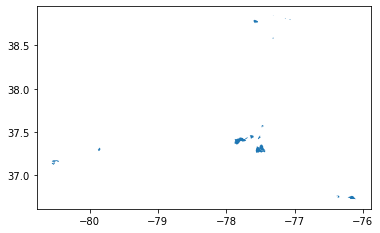

In [110]:
#important
shp[shp['unique_id_2'].isin(['041111',
 '041216',
 '041314',
 '041319',
 '041412',
 '059700',
 '121203',
 '153109',
 '153315',
 '161405',
 '510112',
 '510309',
 '550006',
 '550049',
 '750004',
 '760114',
 '760215'])].plot()

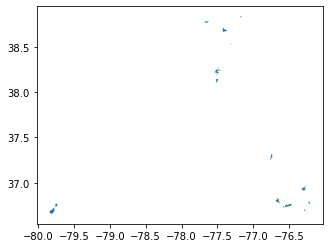

In [111]:
#important
final[final['unique_id_2'].isin(['059513-8',
 '089304-5',
 '089505-5',
 '095202-1',
 '095504-1',
 '153110-1',
 '153112-1',
 '153210-1',
 '153312-1',
 '153609-1',
 '177103-1',
 '177402-1',
 '177702-1',
 '177703-1',
 '177704-1',
 '550020-3',
 '550040',
 '550047',
 '650215-2',
 '710104-2',
 '800302-3',
 '800404-3',
 '800504-3',
 '800602-3'])].plot()

**It looks like the remaining geometries do not match up, so it is not a unique id problem, it is an actual missing area problem.**

In [112]:
set(df_with_absentee_reallocated.unique_id_2) - set(final.unique_id_2)
# see that unique_2 does not match like unique_1 but for plotting purposes it does not matter because those ids do overlap.

{'003407',
 '003507',
 '041111-4',
 '077401-9',
 '095104-2',
 '121203-9',
 '153106-1',
 '153109-1',
 '161405-6',
 '191702-9',
 '520004-9',
 '550006-4',
 '550049-4',
 '685003-10',
 '760114-4'}

## Join election results and shapefile

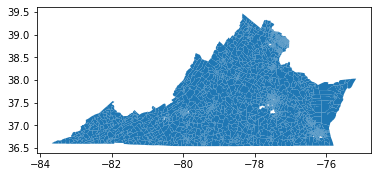

In [113]:
join = gpd.GeoDataFrame(pd.merge(df_with_absentee_reallocated, shp, on = 'unique_id_2', how = 'inner'), crs = proj)
join.plot()

In [114]:
join.shape

(2438, 32)

In [115]:
shp.shape

(2455, 19)

In [116]:
df_with_absentee_reallocated.unique_id_2.nunique()

2462

In [117]:
set(df_with_absentee_reallocated.unique_id_2) - set(shp.unique_id_2)

{'059513-8',
 '089304-5',
 '089505-5',
 '095202-1',
 '095504-1',
 '153110-1',
 '153112-1',
 '153210-1',
 '153312-1',
 '153609-1',
 '177103-1',
 '177402-1',
 '177702-1',
 '177703-1',
 '177704-1',
 '550020-3',
 '550040',
 '550047',
 '650215-2',
 '710104-2',
 '800302-3',
 '800404-3',
 '800504-3',
 '800602-3'}

# Validation

## Shapfile validation

In [118]:
join.head()

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP_x,countyfp_cd,...,ORIG_NAME,ORIG_CODE,RELATE,NAME,VINTAGE,FUNCSTAT,JUSTIFY,MTFCC,unique_id_y,unique_id_1_y
0,1.0,101 - Bowling Green,725.0,357.0,0.0,1,0.0,Caroline County,033,033-1,...,None,None,None,Bowling Green,90,N,None,G5240,033101,033101
1,3.0,102 - Sparta,518.0,305.0,1.0,1,0.0,Caroline County,033,033-1,...,None,None,None,Sparta,90,N,None,G5240,033102,033102
2,4.0,201 - North Madison,428.0,506.0,0.0,1,0.0,Caroline County,033,033-1,...,None,None,None,North Madison,90,N,None,G5240,033201,033201
3,5.0,202 - South Madison,640.0,520.0,0.0,1,0.0,Caroline County,033,033-1,...,None,None,None,South Madison,90,N,None,G5240,033202,033202
4,7.0,301 - Port Royal,281.0,196.0,0.0,1,0.0,Caroline County,033,033-1,...,None,None,None,Port Royal,90,N,None,G5240,033301,033301


In [119]:
join.columns

Index(['index', 'Pct', 'G18HORREP', 'G18HORDEM', 'G18HORWRI', 'CON_DIST',
       'G18HORLIB', 'LOCALITY', 'COUNTYFP_x', 'countyfp_cd', 'vtdst',
       'unique_id_x', 'unique_id_1_x', 'unique_id_2', 'geometry', 'STATEFP',
       'COUNTYFP_y', 'VTDST', 'NAMELSAD', 'VTDI', 'LSAD', 'CHNG_TYPE',
       'ORIG_NAME', 'ORIG_CODE', 'RELATE', 'NAME', 'VINTAGE', 'FUNCSTAT',
       'JUSTIFY', 'MTFCC', 'unique_id_y', 'unique_id_1_y'],
      dtype='object')

In [120]:
set(final['unique_id_2']) - set(join['unique_id_2'])

{'003499',
 '003599',
 '041111',
 '059513-8',
 '059700',
 '077401',
 '089304-5',
 '089505-5',
 '095104',
 '095202-1',
 '095504-1',
 '121203',
 '153106',
 '153109',
 '153110-1',
 '153112-1',
 '153210-1',
 '153312-1',
 '153609-1',
 '161405',
 '177103-1',
 '177402-1',
 '177702-1',
 '177703-1',
 '177704-1',
 '191702',
 '520004',
 '550006',
 '550020-3',
 '550040',
 '550047',
 '550049',
 '650215-2',
 '685003',
 '710104-2',
 '760114',
 '800302-3',
 '800404-3',
 '800504-3',
 '800602-3'}

In [121]:
shp_final_merge = pd.merge(join, final, on = 'unique_id_2', how = 'outer', suffixes = ['_x', '_y'])

In [122]:
join['geometry'].geom_almost_equals(final['geometry'], decimal = 0)

/Users/lilyfalk/anaconda3/lib/python3.8/site-packages/geopandas/base.py:39: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


0       False
1       False
2       False
3       False
4       False
        ...  
2458    False
2459    False
2460    False
2461    False
2462    False
Length: 2463, dtype: bool

In [123]:
join_shapes = gpd.GeoDataFrame(shp_final_merge, geometry = 'geometry_x')
final_shapes = gpd.GeoDataFrame(shp_final_merge, geometry = 'geometry_y')
vals = join_shapes.geom_almost_equals(final_shapes, decimal = 0)
print(vals.value_counts())

True     1822
False     656
dtype: int64


153    42
059    42
107    38
550    33
700    24
       ..
049     1
680     1
169     1
173     1
007     1
Name: unique_id, Length: 92, dtype: int64


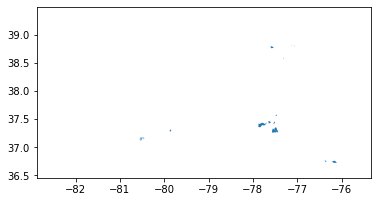

In [124]:
print(shp_final_merge[~vals]['unique_id'].str[0:3].value_counts())
diff_precincts = gpd.GeoDataFrame(shp_final_merge[~vals], geometry = 'geometry_x', crs = proj)

shp_difference = gpd.overlay(join_shapes, final_shapes, how = 'symmetric_difference')
shp_difference.plot()

      index               Pct  G18HORREP_x  G18HORDEM_x  G18HORWRI_x  \
1       3.0      102 - Sparta        518.0        305.0          1.0   
4       7.0  301 - Port Royal        281.0        196.0          0.0   
13     25.0       201 - North        386.0        655.0          0.0   
14     27.0       301 - South        796.0        448.0          2.0   
15     29.0     401 - Central        642.0        503.0          0.0   
...     ...               ...          ...          ...          ...   
2473    NaN               NaN          NaN          NaN          NaN   
2474    NaN               NaN          NaN          NaN          NaN   
2475    NaN               NaN          NaN          NaN          NaN   
2476    NaN               NaN          NaN          NaN          NaN   
2477    NaN               NaN          NaN          NaN          NaN   

     CON_DIST_x  G18HORLIB_x       LOCALITY_x COUNTYFP_x countyfp_cd  ...  \
1             1          0.0  Caroline County        033  

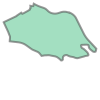

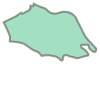

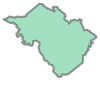

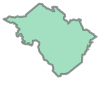

In [125]:
#Show a random difference
test = shp_final_merge[~vals].sample(axis = 0, n=1).index[0]
print(shp_final_merge[~vals])
display(shp_final_merge.iloc[test]['geometry_x'])
display(shp_final_merge.iloc[test]['geometry_y'])

test = shp_final_merge[~vals].sample(axis = 0).index[0]
display(shp_final_merge.iloc[test]['geometry_x'])
display(shp_final_merge.iloc[test]['geometry_y'])

## Merge and check precinct level election results

In [126]:
print(set(final.unique_id_1) - set(df_with_absentee_reallocated.unique_id_1))
final[final.unique_id_1 == '059700-11'] #dont recreate in election result df because 0 votes

{'059700-11'}


,COUNTYFP,LOCALITY,VTDST,PRECINCT,CON_DIST,G18HORDEM,G18HORREP,G18HORLIB,G18HORWRI,geometry,unique_id,unique_id_1,unique_id_2
600,059,Fairfax County,000700,Fairfax Court,11,0,0,0,0,"POLYGON Z ((-77.31648 38.84615 0.00000, -77.31...",059700,059700-11,059700


In [127]:
set(df_with_absentee_reallocated.unique_id_1) - set(final.unique_id_1)

set()

In [128]:
final.columns

Index(['COUNTYFP', 'LOCALITY', 'VTDST', 'PRECINCT', 'CON_DIST', 'G18HORDEM',
       'G18HORREP', 'G18HORLIB', 'G18HORWRI', 'geometry', 'unique_id',
       'unique_id_1', 'unique_id_2'],
      dtype='object')

In [129]:
final_df_merge = pd.merge(df_with_absentee_reallocated, final, on = 'unique_id_1')

In [130]:
col_list = ['G18HORDEM', 'G18HORREP', 'G18HORLIB', 'G18HORWRI']

In [132]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff != 0):
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]['unique_id_1'])
                if (diff>max_diff):
                    max_diff = diff
                    #add line to check percent from total vote difference is
                    perc_diff_from_vest = (diff/df.iloc[j][right_Data])*100
                    print("New max diff is: ", str(max_diff))
                    print('% difference from VEST total is: ', str(perc_diff_from_vest))
                    print(df.iloc[j]['unique_id_1'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]['unique_id_1'])
        else:
            matching_rows +=1
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
        #add line for % of total vote that difference is
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 5")
    diff_list.sort()

In [133]:
validater_row(final_df_merge, col_list)

New max diff is:  1.0
% difference from VEST total is:  0.13774104683195593
033101-1
New max diff is:  2.0
% difference from VEST total is:  20.0
085304-1
There are  2462  total rows
1119  of these rows have election result differences
1343  of these rows are the same

The max difference between any one shared column in a row is:  2.0
The average difference is:  1.000739098300074
There are  0 precinct results with a difference greater than 5


In [134]:
final[final.unique_id_1 == '085304-1']

,COUNTYFP,LOCALITY,VTDST,PRECINCT,CON_DIST,G18HORDEM,G18HORREP,G18HORLIB,G18HORWRI,geometry,unique_id,unique_id_1,unique_id_2
824,085,Hanover County,000304,Atlee,1,1492,2331,0,10,"POLYGON Z ((-77.45231 37.68616 0.00000, -77.45...",085304,085304-1,085304


In [135]:
df_with_absentee_reallocated[df_with_absentee_reallocated.unique_id_1 == '085304-1']

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP,countyfp_cd,vtdst,unique_id,unique_id_1,unique_id_2
61,65.0,304 - Atlee,2331.0,1492.0,8.0,1,0.0,Hanover County,085,085-1,304,085304,085304-1,085304
